Read And Play with redMaPPer Catalog from cosmoDC2 v1.1.4
---------------------------------------------------------

This notebook shows how to read in the new redMaPPer catalog run on cosmoDC2 v1.1.4.

For reference, the commands to get the data that were used as an input to redmapper were:
```python
import GCRCatalogs
from astropy.table import Table

gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4')
quantities_wanted = ['galaxy_id', 'ra', 'dec', 'redshift', 
                     'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst',
                     'mag_true_z_lsst', 'mag_true_y_lsst', 'halo_id',
                     'halo_mass', 'is_central']
query = GCRCatalogs.GCRQuery('mag_true_z_lsst < 25.5')
data = Table(gc.get_quantities(quantities_wanted, [query]))
data.write('cosmoDC2_v1.1.4_raw.fits', format='fits')
```

In [1]:
# Until this is merged, you need my version of gcr-catalogs
import sys
sys.path.insert(0, '/global/homes/e/erykoff/src/erykoff/gcr-catalogs')

In [2]:
import GCRCatalogs
from astropy.table import Table
import esutil
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Get the redMaPPer catalog
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.2.1py')

In [4]:
# Select out the cluster and member quantities into different lists
quantities = gc.list_all_quantities()
cluster_quantities = [q for q in quantities if 'member' not in q]
member_quantities = [q for q in quantities if 'member' in q]

In [5]:
# Read in the cluster and member data
cluster_data = Table(gc.get_quantities(cluster_quantities))
member_data = Table(gc.get_quantities(member_quantities))

Text(0,0.5,'z_spec_central')

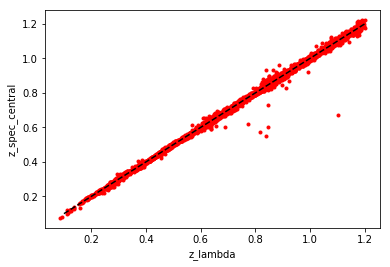

In [6]:
# Compare the cluster photo-z to the central galaxy redshift
plt.plot(cluster_data['redshift'], cluster_data['redshift_true_cg'], 'r.')
plt.plot([0.1, 1.2], [0.1, 1.2], 'k--')
plt.xlabel('z_lambda')
plt.ylabel('z_spec_central')

Note that the outliers here are all miscentered clusters

## Now let's match the cluster centrals and members by the galaxy ID to look at the central colors

In [7]:
# First, we will want to read in the "truth" as a comparison
gc_truth = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
quantities_wanted = ['mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'mag_true_y_lsst', 'redshift']
query = GCRCatalogs.GCRQuery('(is_central == True) & (halo_mass > 5e13)')
truth_data = Table(gc_truth.get_quantities(quantities_wanted, [query]))

In [8]:
a, b = esutil.numpy_util.match(cluster_data['id_cen_0'], member_data['id_member'])

Text(0,0.5,'g-r of central galaxy')

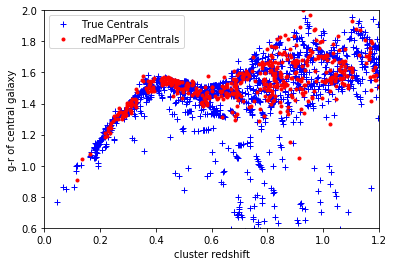

In [9]:
plt.plot(truth_data['redshift'], truth_data['mag_true_g_lsst'] - truth_data['mag_true_r_lsst'], 'b+', label='True Centrals')
plt.plot(cluster_data['redshift'][a], member_data['mag_g_lsst_member'][b] - member_data['mag_r_lsst_member'][b], 'r.', label='redMaPPer Centrals')
plt.xlim(0.0, 1.2)
plt.ylim(0.6,2.0)
plt.legend()
plt.xlabel('cluster redshift')
plt.ylabel('g-r of central galaxy')

Text(0,0.5,'r-i of central galaxy')

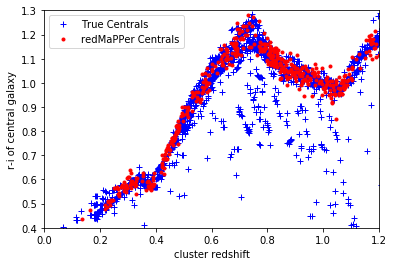

In [10]:
plt.plot(truth_data['redshift'], truth_data['mag_true_r_lsst'] - truth_data['mag_true_i_lsst'], 'b+', label='True Centrals')
plt.plot(cluster_data['redshift'][a], member_data['mag_r_lsst_member'][b] - member_data['mag_i_lsst_member'][b], 'r.', label='redMaPPer Centrals')
plt.xlim(0.0, 1.2)
plt.ylim(0.4, 1.3)
plt.legend()
plt.xlabel('cluster redshift')
plt.ylabel('r-i of central galaxy')

Text(0,0.5,'i-z of central galaxy')

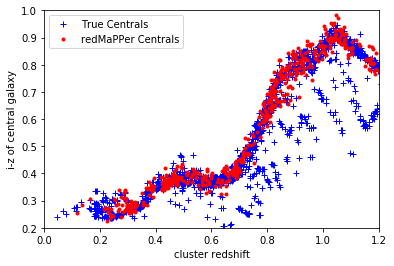

In [11]:
plt.plot(truth_data['redshift'], truth_data['mag_true_i_lsst'] - truth_data['mag_true_z_lsst'], 'b+', label='True Centrals')
plt.plot(cluster_data['redshift'][a], member_data['mag_i_lsst_member'][b] - member_data['mag_z_lsst_member'][b], 'r.', label='redMaPPer Centrals')
plt.xlim(0.0, 1.2)
plt.ylim(0.2, 1.0)
plt.legend()
plt.xlabel('cluster redshift')
plt.ylabel('i-z of central galaxy')

Text(0,0.5,'z-y of central galaxy')

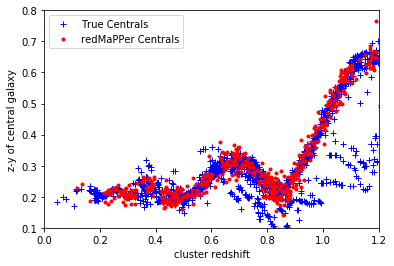

In [12]:
plt.plot(truth_data['redshift'], truth_data['mag_true_z_lsst'] - truth_data['mag_true_y_lsst'], 'b+', label='True Centrals')
plt.plot(cluster_data['redshift'][a], member_data['mag_z_lsst_member'][b] - member_data['mag_y_lsst_member'][b], 'r.', label='redMaPPer Centrals')
plt.xlim(0.0, 1.2)
plt.ylim(0.1, 0.8)
plt.legend()
plt.xlabel('cluster redshift')
plt.ylabel('z-y of central galaxy')

## Match Clusters and Members to look at the median member redshift
This is only possible with mock catalogs where we have true redshifts for all members

In [13]:
# Clean out any members without ztrue information
ok, = np.where(member_data['redshift_true_member'] > 0.0)
mem = member_data[ok]

In [14]:
# match clusters to members using cluster_id
a, b = esutil.numpy_util.match(cluster_data['cluster_id'], mem['cluster_id_member'])
# Use the reverse indicies from esutil histogram to group these into cluster bins
h, rev = esutil.stat.histogram(a, rev=True)
mem_zmedian = np.zeros(len(cluster_data))
for i in range(len(cluster_data)):
    i1a = rev[rev[i]: rev[i + 1]]
    mem_zmedian[i] = np.median(mem['redshift_true_member'][i1a])


Text(0,0.5,'Median true redshift from members')

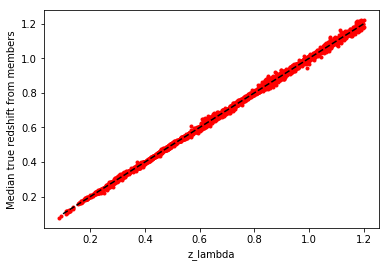

In [15]:
plt.plot(cluster_data['redshift'], mem_zmedian, 'r.')
plt.plot([0.1, 1.2], [0.1, 1.2], 'k--')
plt.xlabel('z_lambda')
plt.ylabel('Median true redshift from members')

The outliers from above are gone ... those were miscentered clusters.

## Look at cluster richness and redshift

Text(0,0.5,'log10(Cluster Richness)')

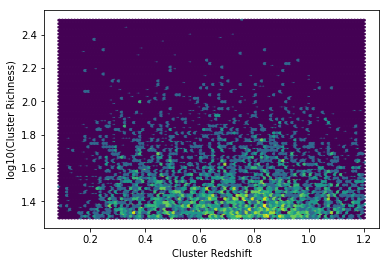

In [16]:
plt.hexbin(cluster_data['redshift'], np.log10(cluster_data['richness']), bins='log')
plt.xlabel('Cluster Redshift')
plt.ylabel('log10(Cluster Richness)')